<h1>Classification - Single Class</h1>

This is a notebook that demonstrates a single class classification. It uses the MNIST data set - a collection of 70000 hand written digit images. Each image is 28 * 28 pixels and labeled with a single digit. 

In this notebook we train a model to distinguish between the number 5 to the rest of the digits. We explore the metrics (precision, recall, etc...) of our trained model and try out 2 different models. 

In [298]:
from sklearn.datasets import fetch_mldata
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%config IPCompleter.greedy=True

In [299]:
#fetch the data
mnist = fetch_mldata('MNIST original')

In [300]:
#get data and targets
target = mnist.target.reshape(mnist.target.shape[0], 1)
data = mnist.data

print ('shape of data and targets')
print ('\ndata shape: ', data.shape)
print ('target shape: ', target.shape)

shape of data and targets

data shape:  (70000, 784)
target shape:  (70000, 1)


In [301]:
#target proportions
def get_proportions(data):
    target_df = pd.DataFrame(data)
    value_counts = target_df[0].value_counts()
    num_targets = target_df.shape[0]

    return value_counts / len(data)

print ('target proportions')
get_proportions(target)

target proportions


1.0    0.112529
7.0    0.104186
3.0    0.102014
2.0    0.099857
9.0    0.099400
0.0    0.098614
6.0    0.098229
8.0    0.097500
4.0    0.097486
5.0    0.090186
Name: 0, dtype: float64

See arbitrary examples from the data


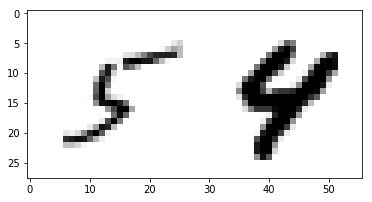

In [302]:
#see what an image from data looks like
print ('See arbitrary examples from the data')

digit_5 = data[35000].reshape(28, 28)
digit_4 = data[29999].reshape(28, 28)
digits = np.c_[digit_5, digit_4]
plt.imshow(digits, cmap = matplotlib.cm.binary, interpolation="nearest")

In [303]:
#train/test split (MNIST data set is already ready for split)
print ('splitting data to train and test sets')
X_train, X_test, y_train, y_test = data[:60000], data[60000:], target[:60000], target[60000:]

#shuffle training set so that same numbers don't appear in a row
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

#check train targets proportions
print ('\ntrain targets proportions')
get_proportions(y_train)

splitting data to train and test sets

train targets proportions


1.0    0.112367
7.0    0.104417
3.0    0.102183
2.0    0.099300
9.0    0.099150
0.0    0.098717
6.0    0.098633
8.0    0.097517
4.0    0.097367
5.0    0.090350
Name: 0, dtype: float64

In [304]:
from sklearn.linear_model import SGDClassifier

print ('training SGD Classifier...')

#Binary classifier for the digit 5- if 5 true, if not 5 false
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits. 
y_test_5 = (y_test == 5)

#stochastic gradient descent classifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5.ravel())

#predict on our some_digit from before
print ('\ntesting predictions on arbitrary examples')
print ('testing 5: ', sgd_clf.predict([digit_5.ravel()]))
print ('testing 4: ', sgd_clf.predict([digit_4.ravel()]))

training SGD Classifier...

testing predictions on arbitrary examples
testing 5:  [ True]
testing 4:  [False]


In [305]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

#k-fold cv implementation
def cross_validation(classifier, X, y, n_splits = 3):
    skfolds = StratifiedKFold(n_splits=n_splits, random_state=42)

    #need to reshape y to (y,) for cv
    y = y.reshape(y.shape[0],)
    
    print ('Cross validation results')
    
    for train_index, test_index in skfolds.split(X, y): 
        clone_clf = clone(classifier)
        X_train_folds = X[train_index]
        y_train_folds = (y[train_index])
        X_test_fold = X[test_index]
        y_test_fold = (y[test_index])

        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)

        print(n_correct / len(y_pred)) 

#testing our 5-only classifier
cross_validation(sgd_clf, X_train, y_train_5)

Cross validation results
0.95215
0.95445
0.96895


In [306]:
from sklearn.model_selection import cross_val_score
from sklearn.base import BaseEstimator

#what accuracy will we get if we predict not-5 all the time?
#we're getting 90% (since only 10% of the examples are 5 - see proportions above).
#This means that accuracy measurement does not tell us much here
class Never5Classifier(BaseEstimator): 
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()

print ('Accuracy for predicting not-5 all the time')
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

Accuracy for predicting not-5 all the time


array([ 0.91055,  0.90875,  0.90965])

In [307]:
from sklearn.model_selection import cross_val_predict

#Creating a confusion matrix for performance measuremence

#returns the predictions (instead of the performance scores)
y_train_5_reshaped = y_train_5.reshape(y_train_5.shape[0],)
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5_reshaped, cv=3)
y_train_actuals = y_train_5

confusion_mat = confusion_matrix(y_train_actuals, y_train_pred)
print ('Confusion matrix')
print (confusion_mat)

tp = confusion_mat[1][1]
fp = confusion_mat[0][1]
tn = confusion_mat[0][0]
fn = confusion_mat[1][0]

print ('TP: {}, FP: {}, TN: {}, FN: {} \n'.format(tp, fp, tn, fn))

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = 2 * ((precision * recall) / (precision + recall))
print ('precision: ', precision)
print ('recall: ', recall)
print ('f1: ', f1)


Confusion matrix
[[54267   312]
 [ 2177  3244]]
TP: 3244, FP: 312, TN: 54267, FN: 2177 

precision:  0.912260967379
recall:  0.598413576831
f1:  0.722735880584


metrics- SGD classifier

confidence for a single positive example:  [ 218762.61191561]
confidence for a single negative example:  [-190144.02897021]
number of positives:  3556
number of positives:  56444
avreage positive confidence:  173735.89292
avreage negative confidence:  -550157.50227

Plot of precision-recall pairs for increasing threshold values
precision score for threshold 70000:  0.950472589792


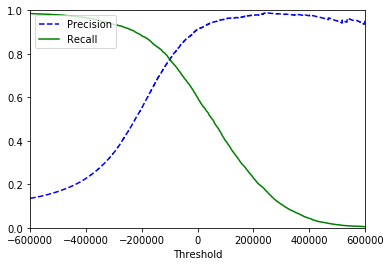

In [308]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

print ('metrics- SGD classifier')

#precision/recall tradeoff
#useful for when the positive examples are sparse

#by default the SGD classifier's threshold for positive example is above 0.
#get the confidence score of the classifier for true and false examples
print ('\nconfidence for a single positive example: ', sgd_clf.decision_function([digit_5.ravel()]))
print ('confidence for a single negative example: ', sgd_clf.decision_function([digit_4.ravel()]))

#get confidence level for each example in training set
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5_reshaped, cv=3, method="decision_function")
y_positive = y_scores[y_scores > 0.0]
y_negative = y_scores[y_scores < 0.0]

print ('number of positives: ', len(y_positive))
print ('number of positives: ', len(y_negative))
print ('avreage positive confidence: ', np.mean(y_positive))
print ('avreage negative confidence: ', np.mean(y_negative))

#plot precision and recall for increasing thresholds
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x_range = [-600000, 600000]): 
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision") 
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall") 
    plt.xlim(x_range)
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

#get the precision and recall pairs for increasing threshold values
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

print ('\nPlot of precision-recall pairs for increasing threshold values')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

#example: setting a threshold that produces 90% precision
y_train_pred_90 = (y_scores > 70000)
print ('precision score for threshold 70000: ', precision_score(y_train_actuals, y_train_pred_90))


ROC Curve- SGD classifier
Area under the curve:  0.959169759187


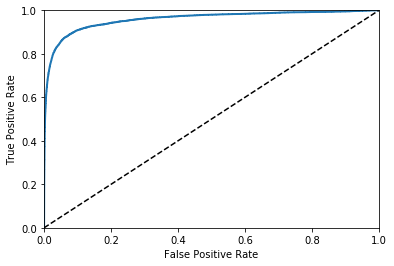

In [309]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

#ROC Curve
#plots true positive rates (recall) against false positive rates for increasing threshold values

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None): 
    plt.plot(fpr, tpr, linewidth=2, label=label) 
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
print ('ROC Curve- SGD classifier')
plot_roc_curve(fpr, tpr)

print ('Area under the curve: ', roc_auc_score(y_train_5, y_scores))

In [310]:
from sklearn.ensemble import RandomForestClassifier

print ('Training Random Forest classifier...')

#Changing our model - random forest classifier

#get the probabilities for True and False classifications
#column 1 - prob of negative, column 2 - prob of positive
#default cutoff - 0.5
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train, y_train_5_reshaped)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5_reshaped, cv=3, method="predict_proba")


Training Random Forest classifier...


metrics- Random Forest classifier

confidence (probability) for a single positive example:  [[ 0.  1.]]
confidence (probability) for a single negative example:  [[ 1.  0.]]
Number of positive predictions:  4948
Number of negative predictions:  4555
avreage positive confidence (probability):  0.5
avreage negative confidence (probability):  0.5

Plot of precision-recall pairs for increasing threshold values
precision score for 0.3 threshold : 0.8480327868852459 
recall score for 0.3 threshold : 0.9542519830289614


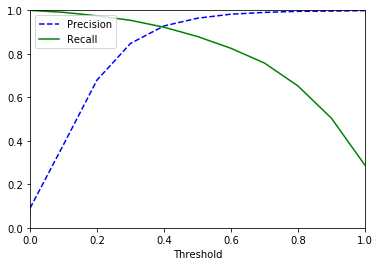

In [311]:
print ('metrics- Random Forest classifier')

y_positive= y_probas_forest[y_probas_forest[:,1] >= 0.5]
y_negative = y_probas_forest[y_probas_forest[:,0] < 0.5]

print ('\nconfidence (probability) for a single positive example: ', forest_clf.predict_proba([digit_5.ravel()]))
print ('confidence (probability) for a single negative example: ', forest_clf.predict_proba([digit_4.ravel()]))
print ('Number of positive predictions: ', len(y_positive))
print ('Number of negative predictions: ', len(y_negative))
print ('avreage positive confidence (probability): ', np.mean(y_positive))
print ('avreage negative confidence (probability): ', np.mean(y_negative))

#get the precision and recall pairs for increasing threshold values
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_probas_forest[:,1])

print ('\nPlot of precision-recall pairs for increasing threshold values')
plot_precision_recall_vs_threshold(precisions, recalls, thresholds, x_range = [0, 1])

#Example: getting recall of ~95% and precision of ~84%
threshold = 0.30
y_recall_95 = (y_probas_forest[:,1] >= threshold)
print ('precision score for {} threshold : {} '.format(threshold, precision_score(y_train_actuals, y_recall_95)))
print ('recall score for {} threshold : {}'.format(threshold, recall_score(y_train_actuals, y_recall_95)))



Plot ROC Curve or SGD classifier against random forest
Area under the curve for the random forest classifers ROC curve:  0.991558393181


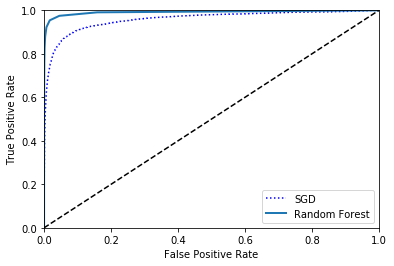

In [312]:
print ('\nPlot ROC Curve or SGD classifier against random forest')
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

print ('Area under the curve for the random forest classifers ROC curve: ', roc_auc_score(y_train_5, y_scores_forest))